In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [4]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 56776955.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


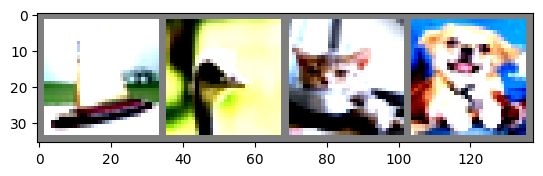

ship  bird  cat   dog  


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [7]:
# !pip install torchsummary

In [8]:
import torch.nn.functional as F
from torchsummary import summary

dropout_value = 0.03
group_value = 4
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(group_value,16),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(16,32,3, padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(group_value,32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(32,16,1, padding=0, bias=False),
        )
        self.pool1 = nn.MaxPool2d(2, 2) # 16

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(group_value,32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/10/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(group_value, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/14/2

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(group_value, 32),
            nn.Dropout(dropout_value)
        )
        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16/14/2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8/16/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(group_value, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(group_value, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 6/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(group_value, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = x + self.convblock5(x)
        x = self.conv6(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1

In [9]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)
#     test_losses.append(test_loss)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

#     test_acc.append(100. * correct / len(test_loader.dataset))
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []  # List to store misclassified images and labels
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)  # Remove keepdim=True; now shape: [batch_size]
            correct += pred.eq(target).sum().item()

            # Find misclassified indices
            misclassified_idxs = (pred != target).nonzero(as_tuple=False).squeeze()
            for idx in misclassified_idxs:
                if len(misclassified_images) < 10:  # Collect only 10 images
                    img = data[idx].cpu()
                    actual_label = target[idx].item()
                    predicted_label = pred[idx].item()
                    misclassified_images.append((img, predicted_label, actual_label))
                else:
                    break

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return misclassified_images


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    # test(model, device, test_loader)
    misclassified_images = test(model, device, test_loader)


EPOCH: 0


Loss=1.517811894416809 Batch_id=97 Accuracy=32.71: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]



Test set: Average loss: 1.5295, Accuracy: 4421/10000 (44.21%)

EPOCH: 1


Loss=1.2968707084655762 Batch_id=97 Accuracy=48.46: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]



Test set: Average loss: 1.3022, Accuracy: 5273/10000 (52.73%)

EPOCH: 2


Loss=1.128798484802246 Batch_id=97 Accuracy=56.15: 100%|██████████| 98/98 [00:14<00:00,  6.85it/s]



Test set: Average loss: 1.1688, Accuracy: 5804/10000 (58.04%)

EPOCH: 3


Loss=1.1453851461410522 Batch_id=97 Accuracy=61.52: 100%|██████████| 98/98 [00:14<00:00,  6.95it/s]



Test set: Average loss: 1.0703, Accuracy: 6235/10000 (62.35%)

EPOCH: 4


Loss=0.9566308856010437 Batch_id=97 Accuracy=64.77: 100%|██████████| 98/98 [00:14<00:00,  6.81it/s]



Test set: Average loss: 0.9702, Accuracy: 6549/10000 (65.49%)

EPOCH: 5


Loss=0.8429498076438904 Batch_id=97 Accuracy=68.34: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]



Test set: Average loss: 0.9144, Accuracy: 6865/10000 (68.65%)

EPOCH: 6


Loss=0.8608554005622864 Batch_id=97 Accuracy=70.04: 100%|██████████| 98/98 [00:14<00:00,  6.84it/s]



Test set: Average loss: 0.8431, Accuracy: 7038/10000 (70.38%)

EPOCH: 7


Loss=0.7857331037521362 Batch_id=97 Accuracy=72.22: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]



Test set: Average loss: 0.8154, Accuracy: 7149/10000 (71.49%)

EPOCH: 8


Loss=0.8279511332511902 Batch_id=97 Accuracy=73.59: 100%|██████████| 98/98 [00:14<00:00,  6.68it/s]



Test set: Average loss: 0.8053, Accuracy: 7202/10000 (72.02%)

EPOCH: 9


Loss=0.696129322052002 Batch_id=97 Accuracy=74.48: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 0.7697, Accuracy: 7335/10000 (73.35%)

EPOCH: 10


Loss=0.5907561779022217 Batch_id=97 Accuracy=75.71: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]



Test set: Average loss: 0.7489, Accuracy: 7403/10000 (74.03%)

EPOCH: 11


Loss=0.6387572288513184 Batch_id=97 Accuracy=76.57: 100%|██████████| 98/98 [00:14<00:00,  6.77it/s]



Test set: Average loss: 0.7307, Accuracy: 7428/10000 (74.28%)

EPOCH: 12


Loss=0.659599244594574 Batch_id=97 Accuracy=77.28: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 0.7628, Accuracy: 7401/10000 (74.01%)

EPOCH: 13


Loss=0.5816513895988464 Batch_id=97 Accuracy=78.28: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 0.7286, Accuracy: 7517/10000 (75.17%)

EPOCH: 14


Loss=0.6575297117233276 Batch_id=97 Accuracy=78.65: 100%|██████████| 98/98 [00:14<00:00,  6.83it/s]



Test set: Average loss: 0.7094, Accuracy: 7551/10000 (75.51%)

EPOCH: 15


Loss=0.5253109931945801 Batch_id=97 Accuracy=79.30: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]



Test set: Average loss: 0.7192, Accuracy: 7564/10000 (75.64%)

EPOCH: 16


Loss=0.6113300919532776 Batch_id=97 Accuracy=80.08: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 0.6866, Accuracy: 7626/10000 (76.26%)

EPOCH: 17


Loss=0.5191327929496765 Batch_id=97 Accuracy=80.28: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s]



Test set: Average loss: 0.6859, Accuracy: 7709/10000 (77.09%)

EPOCH: 18


Loss=0.5535556674003601 Batch_id=97 Accuracy=81.03: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]



Test set: Average loss: 0.6908, Accuracy: 7638/10000 (76.38%)

EPOCH: 19


Loss=0.5837746262550354 Batch_id=97 Accuracy=81.39: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]



Test set: Average loss: 0.6593, Accuracy: 7783/10000 (77.83%)



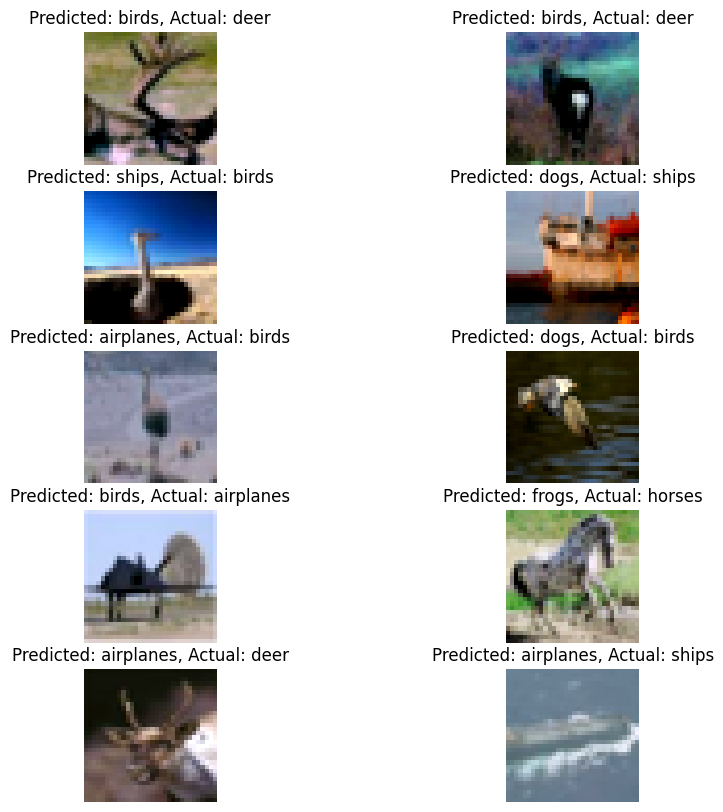

In [10]:
import matplotlib.pyplot as plt

def visualize_misclassified_images(misclassified_images):
    classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
    plt.figure(figsize=(10, 10)) #original images were 32x32
    for i, (image, pred, actual) in enumerate(misclassified_images[:10]):
        image = image.numpy().transpose(1, 2, 0)  # Convert to (height, width, channel)
        mean = [0.4914, 0.4822, 0.4465] #3 values for 2 channels, RGB
        std = [0.247, 0.243, 0.261]
        image = image * std + mean  # Undo normalization
        image = np.clip(image, 0, 1)  # Clip values to valid range

        plt.subplot(5, 2, i+1)
        plt.imshow(image)

        plt.title(f"Predicted: {classes[pred]}, Actual: {classes[actual]}")
        plt.axis('off')
    plt.show()

visualize_misclassified_images(misclassified_images)


In [11]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): GroupNorm(4, 16, eps=1e-05, affine=True)
    (3): Dropout(p=0.03, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): GroupNorm(4, 32, eps=1e-05, affine=True)
    (3): Dropout(p=0.03, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): GroupNorm(4, 32, eps=1e-05, affine=True)
    (3): Dropout(p=0.03, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
 

In [12]:
t = [train_items.item() for train_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

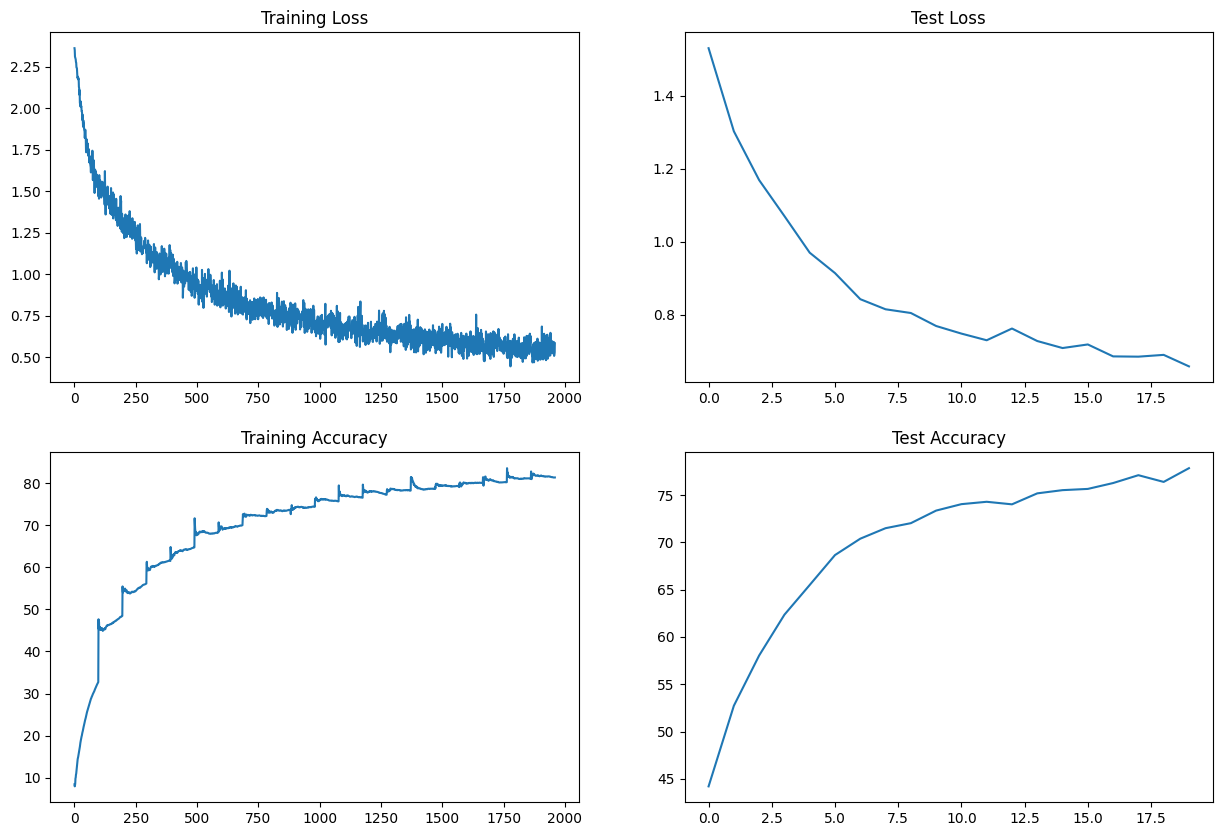

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")